# Capstone EDA

## Questions for Exploration
1. Are there any entries in the data that do not make sense(e.g. Monthly Income of 1 billion)?
2. How does a change in age impact the likelihood to default on the loans? What about the other variables?
3. Is any of the information we collected redundant?

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as stats

import os

PROJECT_ROOT_DIR = "."

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "capstone_images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

%matplotlib inline

In [2]:
# Competiton training dataset and outcome variable
credit = pd.read_csv('cs-training.csv', index_col=0)
delinq = credit.SeriousDlqin2yrs

## Brief Data Exploration

In [3]:
credit.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


It looks very nice. But we will find many values that do not make sense and will have to be taken care of. We have a few different kinds of numerical data, though. There are counts (e.g. "Number of times 90 days late"), percentages (e.g. Debt Ratio), and quantities (e.g. "Monthly Income").

In [4]:
credit.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


The "max" row shows some values that do not even appear to be on the same scale. Look at debt ratio. This is supposed to be a percentage, yet someone has reported a debt ratio of 32,966,400%. I'll have to be wary of outliers.

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


Roughly 20% of the people in our dataset did not report a monthly income. Some of those did not report their number of dependents either. I am going to exclude them for now. But I do not think it is wise to give up 20% of our business/data. For this reason, I will try to impute values for these later, when I am testing the model. This will allow me to get instant feedback and know if I am making good decisions for the values I impute.

In [6]:
credit_dropna = credit.dropna()
delinq_dropna = credit_dropna['SeriousDlqin2yrs']

In [7]:
credit_dropna.shape

(120269, 11)

Saving figure Initial Histograms


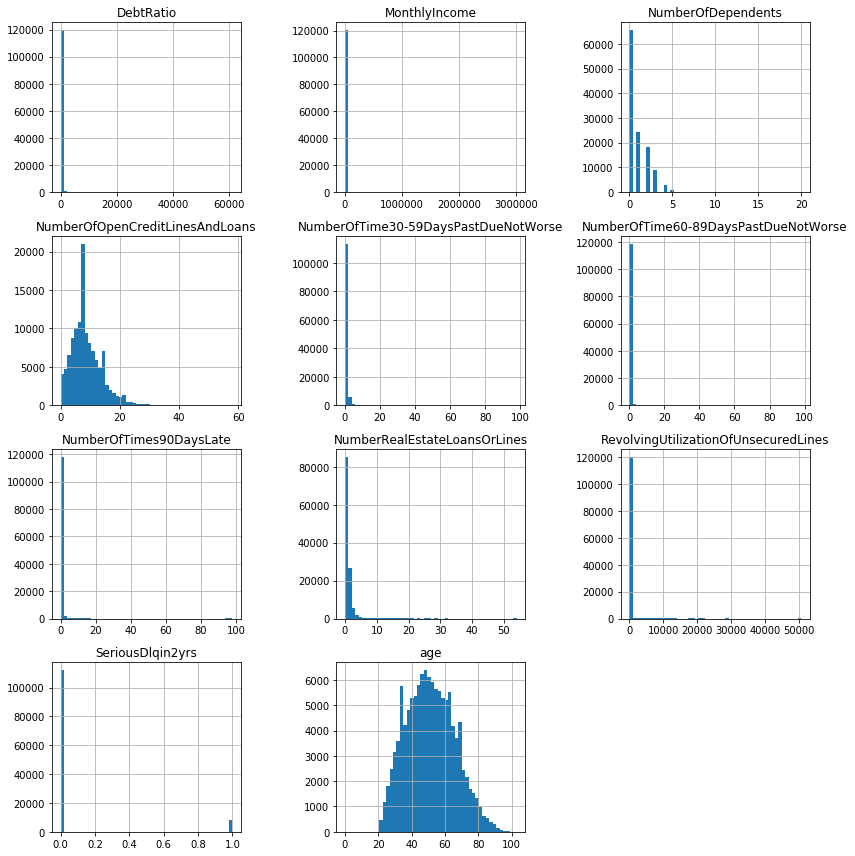

In [8]:
credit_dropna.hist(bins=50, figsize=(12,12))
save_fig('Initial Histograms')
plt.show()

The histograms above are just a first peek. From them, we can confirm that most of our variables are heavily skewed right.

From what we can see above, age would be normally distributed if not for the minimum age requirement of 21. Many other variables are hard to even see because of the extreme values present.

The variables containing these extreme values include:
- DebtRatio
- MonthlyIncome
- NumberOfTime30-59DaysPastDueNotWorse
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfTimes90DaysDaysLate
- NumberRealEstateLoansOrLines (although this one is not as extreme)
- RevolvingUtilizationOfUnsecuredLines

Because so many of my variables are non-normal, I can already tell that I will use a model that does not require normally distributed features.

Our binary outcome variable "SeriousDlqin2yrs" is showing heavy class imbalance. This tells me:
- To undersample the majority class when finetuning models with GridSearchCV
- To use the area under the ROC curve to measure the success of my models

Saving figure outcome_variable


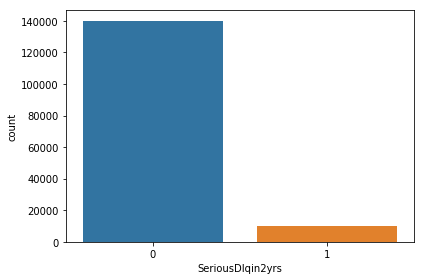

In [9]:
sns.countplot(x='SeriousDlqin2yrs', data=credit)
save_fig('outcome_variable')
plt.show()

# One by One
I will be exploring the distribution of each variable as well as its connection to the outcome variable.

## NumberOfTime30-59DaysPastDueNotWorse

In [10]:
credit['NumberOfTime30-59DaysPastDueNotWorse'].describe()

count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

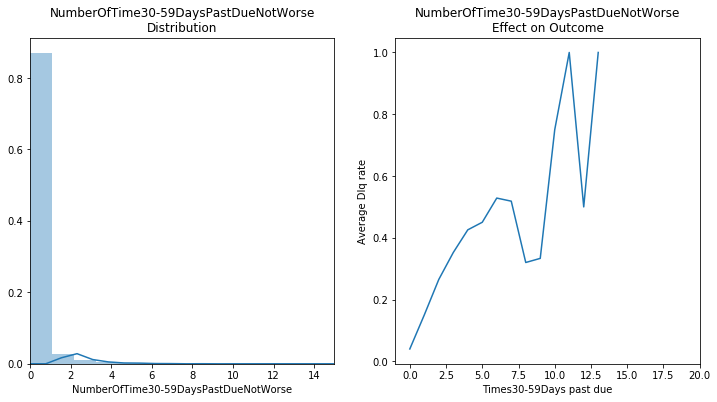

In [11]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['NumberOfTime30-59DaysPastDueNotWorse'], bins=90)
plt.xlim(0,15)
plt.title('NumberOfTime30-59DaysPastDueNotWorse\nDistribution')

x = range(100)
y = []
for n in x:
    y.append(credit[credit['NumberOfTime30-59DaysPastDueNotWorse'] == n]['SeriousDlqin2yrs'].mean())
plt.subplot(1,2,2)
plt.plot(x, y)
plt.title('NumberOfTime30-59DaysPastDueNotWorse\nEffect on Outcome')
plt.xlabel('Times30-59Days past due')
plt.ylabel('Average Dlq rate')
plt.xlim(-1, 20)
plt.show()

In [12]:
credit['NumberOfTime30-59DaysPastDueNotWorse'].value_counts().sort_index()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

### NumberOfTimes30-59DaysPastDueNotWorse Takeaways
#### On it's own:
- There are values up to 13 and then nothing until 96 and 98, where it is clearly capped.

#### Impact on outcome variable:
- Up until 7 times late, it is clearly a higher risk, the more times late you are. Beyond that, there is not enough data and it becomes erratic.

I will reduce the scale of those 269 values of 96/98.

## NumberOfTime60-89DaysPastDueNotWorse

In [13]:
credit['NumberOfTime60-89DaysPastDueNotWorse'].describe()

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

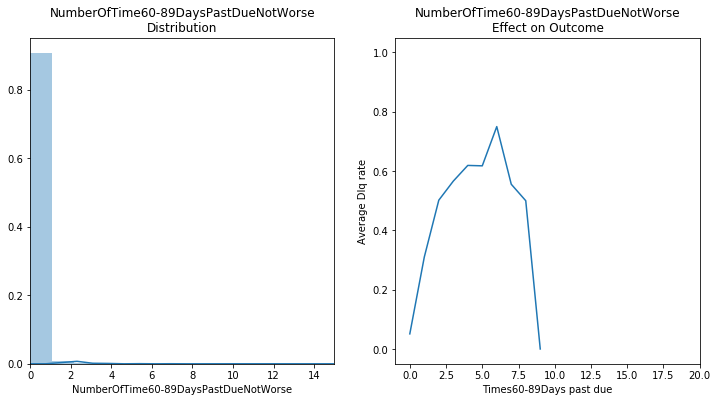

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['NumberOfTime60-89DaysPastDueNotWorse'], bins=90)
plt.xlim(0, 15)
plt.title('NumberOfTime60-89DaysPastDueNotWorse\nDistribution')

plt.subplot(1,2,2)
x = range(100)
y = []
for n in x:
    y.append(credit[credit['NumberOfTime60-89DaysPastDueNotWorse'] == n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('NumberOfTime60-89DaysPastDueNotWorse\nEffect on Outcome')
plt.xlabel('Times60-89Days past due')
plt.ylabel('Average Dlq rate')
plt.xlim(-1, 20)
plt.show()

In [15]:
credit['NumberOfTime60-89DaysPastDueNotWorse'].value_counts().sort_index()

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

### NumberOfTimes60-89DaysPastDueNotWorse Takeaways
#### On it's own:
- This variable has the exact same number of people with 96 and 98 latenesses as 30-59 days late variable did. It is clearly giving much of the same information.

#### Impact on outcome variable:
- Much the same as being 30-59 days late.

I will reduce the scale of the 96 and 98 values.

## NumberOfTimes90DaysLate

In [16]:
credit['NumberOfTimes90DaysLate'].describe()

count    150000.000000
mean          0.265973
std           4.169304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

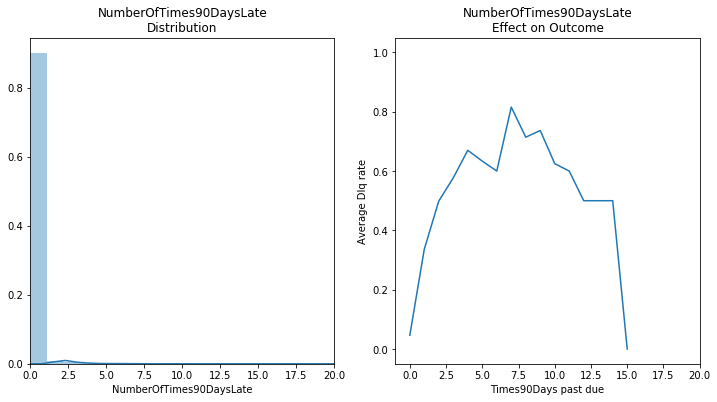

In [17]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['NumberOfTimes90DaysLate'], bins=90)
plt.xlim(0,20)
plt.title('NumberOfTimes90DaysLate\nDistribution')

plt.subplot(1,2,2)
x = range(100)
y = []
for n in x:
    y.append(credit[credit['NumberOfTimes90DaysLate'] == n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('NumberOfTimes90DaysLate\nEffect on Outcome')
plt.xlabel('Times90Days past due')
plt.ylabel('Average Dlq rate')
plt.xlim(-1, 20)
plt.show()

In [18]:
credit['NumberOfTimes90DaysLate'].value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

### NumberOfTimes90DaysLate Takeaways
#### On it's own:
- This variable has the exact same number of people with 96 and 98 latenesses as the 30-59 & 60-89 days late variables did. It is clearly giving much of the same information.

#### Impact on outcome variable:
- See 30-59 days late

I will reduce the scale of the 96 or 98 values.

## Age

In [19]:
credit['age'].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

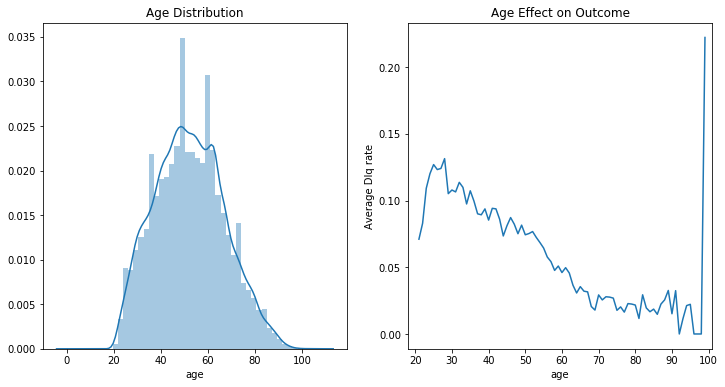

In [20]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['age'])
plt.title('Age Distribution')

plt.subplot(1,2,2)
x = range(100)
y = []
for n in x:
    y.append(credit[credit['age'] == n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('Age Effect on Outcome')
plt.xlabel('age')
plt.ylabel('Average Dlq rate')
plt.xlim(18, 101)
plt.show()

In [21]:
credit[credit.age < 21]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


### Age Takeaways
#### On it's own:
- This is the most normally distributed variable in the dataset.
- The reported age of 0 will be treated as a missing value.

#### Impact on outcome variable:
- Delinquency is definitely more likely for 20-40 than it is for 60-80.

I will impute ages under 21 as the mode.

## RevolvingUtilizationOfUnsecuredLines

In [22]:
credit['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [23]:
credit['RevolvingUtilizationOfUnsecuredLines'].nunique()

125728

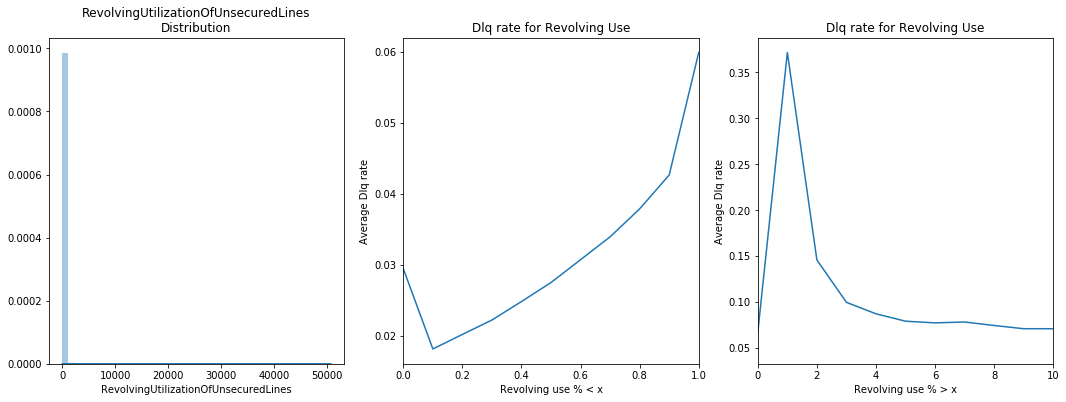

In [24]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.distplot(credit['RevolvingUtilizationOfUnsecuredLines'])
plt.title('RevolvingUtilizationOfUnsecuredLines\nDistribution')

plt.subplot(1,3,2)
x = np.linspace(0, 1, 11)
y = []
for n in x:
    y.append(credit[credit['RevolvingUtilizationOfUnsecuredLines'] <= n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('Dlq rate for Revolving Use')
plt.xlabel('Revolving use % < x')
plt.ylabel('Average Dlq rate')
plt.xlim(0, 1)

plt.subplot(1,3,3)
x = range(0, 100)
y = []
for n in x:
    y.append(credit[credit['RevolvingUtilizationOfUnsecuredLines'] >= n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('Dlq rate for Revolving Use')
plt.xlabel('Revolving use % > x')
plt.ylabel('Average Dlq rate')
plt.xlim(0, 10)
plt.show()

In [25]:
len(credit[credit.RevolvingUtilizationOfUnsecuredLines > 2])

371

In [26]:
len(credit[credit.RevolvingUtilizationOfUnsecuredLines > 100])

223

### RevolvingUtilizationOfUnsecuredLines Takeaways
#### On it's own:
- The max value of 50708 is absurd. This is a percentage. To be over 1, your balance on your credit has to be higher than your credit limit. If you're significantly over one, it is most likely that you have calculated it wrong.
- Only 371 values are higher than 2.0.

#### Impact on outcome variable:
- There are significant changes up to 2.0. Beyond that, the values return back down to similar rates to those at 0. I will treat those as missing because they were probably reported incorrectly.

Values above 2.0 will have their scale reduced.

## NumberRealEstateLoansOrLines

In [27]:
credit['NumberRealEstateLoansOrLines'].describe()

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

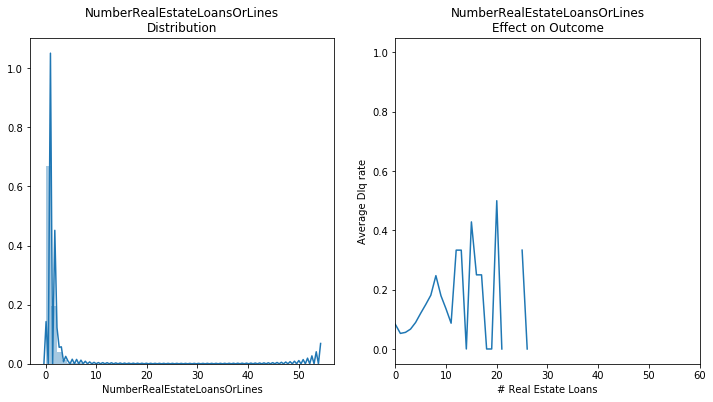

In [28]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['NumberRealEstateLoansOrLines'])
plt.title('NumberRealEstateLoansOrLines\nDistribution')

plt.subplot(1,2,2)
x = range(0, 100)
y = []
for n in x:
    y.append(credit[credit['NumberRealEstateLoansOrLines'] == n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('NumberRealEstateLoansOrLines\nEffect on Outcome')
plt.xlabel('# Real Estate Loans')
plt.ylabel('Average Dlq rate')
plt.xlim(0, 60)
plt.show()

In [29]:
credit.NumberRealEstateLoansOrLines.value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
25        3
18        2
19        2
20        2
23        2
32        1
21        1
26        1
29        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

### NumberRealEstateLoansOrLines Takeaways
#### On it's own:
- The vast majority of those applying for credit have 0 or 1 real estate loan or line.
- A few have pushed the limit beyond 30.

#### Impact on outcome Variable:
- The delinquency rate for the number of real estate loans or lines is erratic.
- There is very little data beyond 30 so we do not know how having that many loans impacts our outcome variable.

Values above 30 will have their scale reduced.

## NumberOfOpenCreditLinesAndLoans

In [30]:
credit['NumberOfOpenCreditLinesAndLoans'].describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

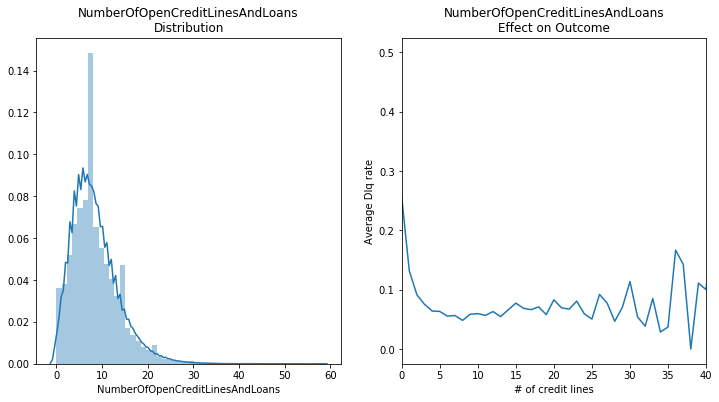

In [31]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['NumberOfOpenCreditLinesAndLoans'])
plt.title('NumberOfOpenCreditLinesAndLoans\nDistribution')

plt.subplot(1,2,2)
x = range(0, 100)
y = []
for n in x:
    y.append(credit[credit['NumberOfOpenCreditLinesAndLoans'] == n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('NumberOfOpenCreditLinesAndLoans\nEffect on Outcome')
plt.xlabel('# of credit lines')
plt.ylabel('Average Dlq rate')
plt.xlim(0, 40)
plt.show()

In [32]:
credit.NumberOfOpenCreditLinesAndLoans.value_counts()

6     13614
7     13245
5     12931
8     12562
4     11609
9     11355
10     9624
3      9058
11     8321
12     7005
2      6666
13     5667
14     4546
1      4438
15     3645
16     3000
17     2370
0      1888
18     1874
19     1433
20     1169
21      864
22      685
23      533
24      422
25      337
26      239
27      194
28      150
29      114
30       88
31       74
32       52
33       47
34       35
35       27
36       18
38       13
40       10
39        9
45        8
43        8
42        8
37        7
48        6
41        4
54        4
49        4
46        3
52        3
51        2
56        2
57        2
50        2
47        2
44        2
53        1
58        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

### NumberOfOpenCreditLinesAndLoans Takeaways
#### On it's own: 
- Most people have fewer than 15 credit lines or loans. Some have pushed the limit to over 50.

#### Impact on outcome variable:
- Those who did not previously have credit lines or loans were significantly more likely to experience distress.
- There are not many people who have past 20, making the delinquency rate erratic for these counts.

This variable might be due for a simple mathematical transformation.

## DebtRatio

In [33]:
credit['DebtRatio'].describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

In [34]:
credit['DebtRatio'].nunique()

114194

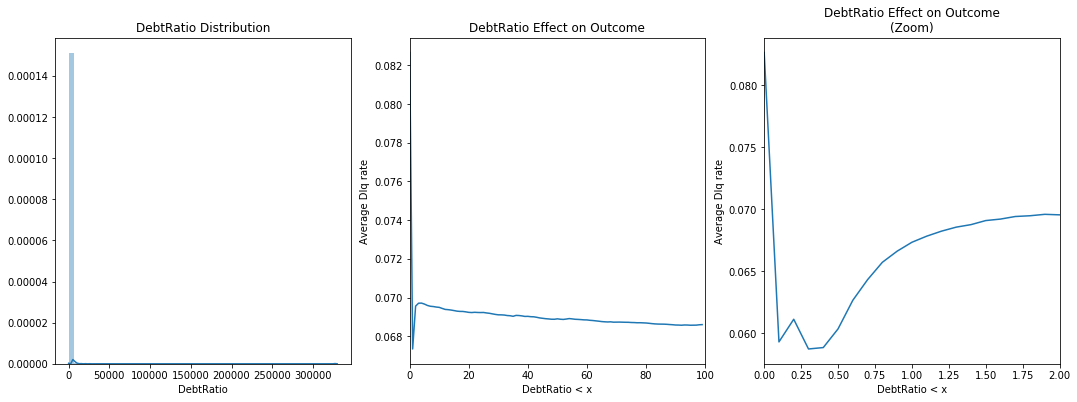

In [35]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.distplot(credit['DebtRatio'])
plt.title('DebtRatio Distribution')

plt.subplot(1,3,2)
x = range(0, 100)
y = []
for n in x:
    y.append(credit[credit['DebtRatio'] <= n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('DebtRatio Effect on Outcome')
plt.xlabel('DebtRatio < x')
plt.ylabel('Average Dlq rate')
plt.xlim(0, 100)

plt.subplot(1,3,3)
x = np.linspace(0,2,21)
y = []
for n in x:
    y.append(credit[credit['DebtRatio'] <= n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('DebtRatio Effect on Outcome\n(Zoom)')
plt.xlabel('DebtRatio < x')
plt.ylabel('Average Dlq rate')
plt.xlim(0, 2)
plt.show()

In [36]:
len(credit[credit.DebtRatio < 2])

118785

In [37]:
len(credit[credit.DebtRatio > 20000])

42

### DebtRatio Takeaways
#### On it's own:
- Values above 1 or 2 are quite rare.

#### Impact on outcome variable:
- Having a DebtRatio of 0 made you more likely to be delinquent.
- Roughly .3-.4 fared the best.

Values above 2.0 will have their scale reduced.

## MonthlyIncome

In [38]:
credit['MonthlyIncome'].describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [39]:
credit['MonthlyIncome'].isnull().sum()

29731

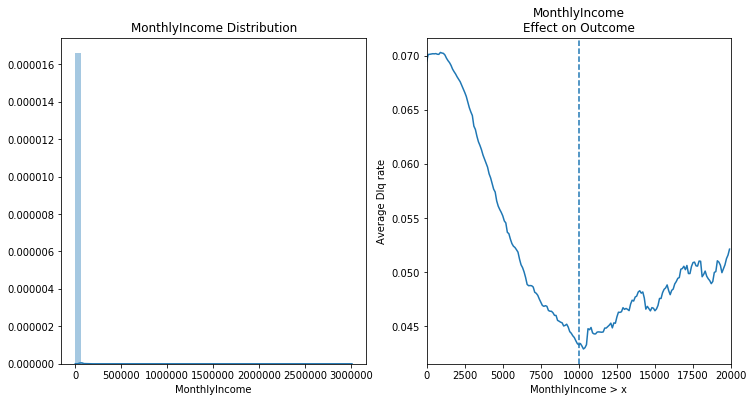

In [40]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['MonthlyIncome'].dropna())
plt.title('MonthlyIncome Distribution')

plt.subplot(1,2,2)
x = range(0, 20000, 100)
y = []
for n in x:
    y.append(credit[credit['MonthlyIncome'] >= n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.axvline(10000, linestyle='--')
plt.title('MonthlyIncome\nEffect on Outcome')
plt.xlabel('MonthlyIncome > x')
plt.ylabel('Average Dlq rate')
plt.xlim(0, 20000)
plt.show()

### MonthlyIncome Takeaways
#### On it's own:
- Roughly 20% of borrowers did not report monthly income. This is way too much to throw out.
- Only 2103 people are making over 20,000 per month and many of these reports are suspicious.

#### Impact on outcome variable:
- The more income, the better you are at repaying your loans... To a point. Beyond 10,000/month, the rate of delinquency goes up again and the small number of datapoints makes it hard to predict

Monthly Incomes of greater than $10,000 will have their scale reduced.

## NumberOfDependents

In [41]:
credit['NumberOfDependents'].describe()

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [42]:
credit.NumberOfDependents.isnull().sum()

3924

In [43]:
credit.NumberOfDependents.value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

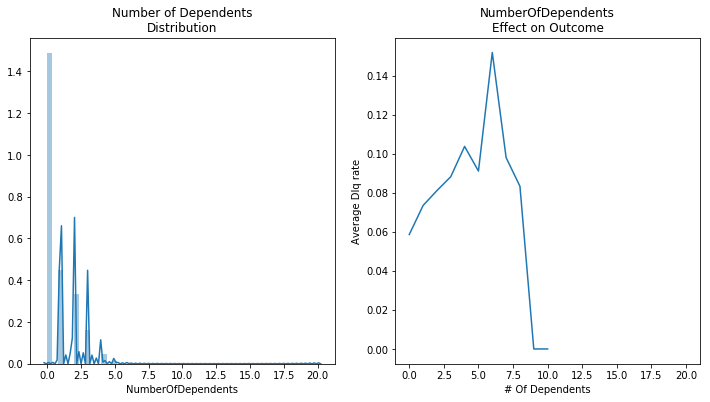

In [44]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(credit['NumberOfDependents'].dropna())
plt.title('Number of Dependents\nDistribution')

plt.subplot(1,2,2)
x = range(21)
y = []
for n in x:
    y.append(credit[credit['NumberOfDependents'] == n]['SeriousDlqin2yrs'].mean())
plt.plot(x, y)
plt.title('NumberOfDependents\nEffect on Outcome')
plt.xlabel('# Of Dependents')
plt.ylabel('Average Dlq rate')
plt.xlim(-1, 21)
plt.show()

### NumberOfDependents Takeaways
#### On it's own:
- 3924 People did not report number of dependents.
- Most people had 0 dependents. More than 5 became rare.

#### Impact on outcome variable:
- The delinquency rate is higher for the more dependents a person has, up to 6, then it drops off and becomes erratic. This is also where the number of datapoints drops off greatly.

Inputs greater than 6 will have their scale reduced.

# Data Exploration Summary:
## Missing Data
The missing data came in the monthly income and number of dependents columns.
- Roughly 20% of borrowers did not report monthly income.
- Roughly 2.5% did not report their # of dependents.

Many variables had strange outliers. These outliers had erratic relationships to the outcome variable. These include:
- age < 21
- NumberOfTime30-59DaysPastDueNotWorse > 13
- NumberOfTime60-89DaysPastDueNotWorse > 11
- NumberOfTimes90DaysLate > 17
- RevolvingUtilizationOfUnsecuredLines > 2
- NumberRealEstateLoansOrLines > 30
- DebtRatio > 2
- MonthlyIncome > 10000
- NumberOfDependents > 6

I will try transforming two columns to make them more normally distributed for the sake of my logistic regression model. These are:
- NumberOfOpenCreditLinesAndLoans
- NumberRealEstateLoansOrLines

## Correlations

In [45]:
corr = credit.corr()
corr

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.115386,0.125587,-0.007602,-0.019746,-0.029669,0.117175,-0.007038,0.102261,0.046048
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005898,-0.001314,0.003961,0.007124,-0.011281,-0.001061,0.006235,-0.001048,0.001557
age,-0.115386,-0.005898,1.000000,-0.062995,0.024188,0.037717,0.147705,-0.061005,0.033150,-0.057159,-0.213303
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001314,-0.062995,1.000000,-0.006542,-0.010217,-0.055312,0.983603,-0.030565,0.987005,-0.002680
DebtRatio,-0.007602,0.003961,0.024188,-0.006542,1.000000,-0.028712,0.049565,-0.008320,0.120046,-0.007533,-0.040673
MonthlyIncome,-0.019746,0.007124,0.037717,-0.010217,-0.028712,1.000000,0.091455,-0.012743,0.124959,-0.011116,0.062647
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.147705,-0.055312,0.049565,0.091455,1.000000,-0.079984,0.433959,-0.071077,0.065322
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.061005,0.983603,-0.008320,-0.012743,-0.079984,1.000000,-0.045205,0.992796,-0.010176
NumberRealEstateLoansOrLines,-0.007038,0.006235,0.033150,-0.030565,0.120046,0.124959,0.433959,-0.045205,1.000000,-0.039722,0.124684
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.057159,0.987005,-0.007533,-0.011116,-0.071077,0.992796,-0.039722,1.000000,-0.010922


Saving figure correlation_map


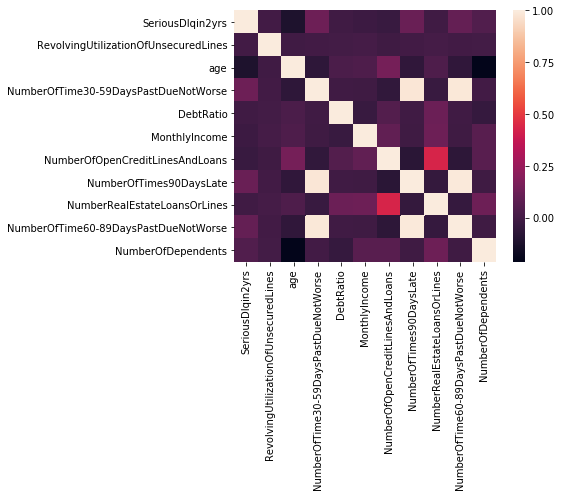

In [46]:
plt.figure(figsize=(8,7))
sns.heatmap(corr)
save_fig('correlation_map')

The lateness variables have huge overlap. The count of lines/loans variables have some correlation as well.

I will try combining them.

# Feature Engineering

### Dealing with outliers and missing values:

In [47]:
retired_income = credit[credit.age > 60]['MonthlyIncome'].mean()
working_income = credit[credit.age <= 60]['MonthlyIncome'].mean()

In [48]:
# Remove outcome variable from DataFrame
def df_remove_outcome(df):
    df = df.drop(columns='SeriousDlqin2yrs')
    return df

# Handling outliers in age
def age_outliers(age):
    if age < 21:
        return 52
    else:
        return age
    
def df_age_outliers(df):
    df['age'] = df['age'].apply(lambda x: age_outliers(x))
    return df

# Handling outliers in RevolvingUtilizationOfUnsecuredLines
def rev_outliers(rev):
    if rev > 2:
        return ((rev - 2) / 10) + 2
    else:
        return rev
    
def df_rev_outliers(df):
    df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: rev_outliers(x))
    return df

# Handling outliers in NumberRealEstateLoansOrLines
def real_estate_outliers(real_estate):
    if real_estate > 30:
        return round((real_estate - 30) / 10) + 30
    else:
        return real_estate

def df_real_estate_outliers(df):
    df['NumberRealEstateLoansOrLines'] = df['NumberRealEstateLoansOrLines'].apply(lambda x: real_estate_outliers(x))
    return df

# Handling outliers in DebtRatio
def debt_outliers(debt):
    if debt > 2:
        return ((debt - 2) / 10) + 2
    else:
        return debt
    
def df_debt_outliers(df):
    df['DebtRatio'] = df['DebtRatio'].apply(lambda x: debt_outliers(x))
    return df

# Handling outliers in NumberOfTime30-59DaysPastDueNotWorse
def late_30_outliers(count):
    if count > 13:
        return round((count - 13) / 10) + 13
    else:
        return count
    
def df_late_30_outliers(df):
    df['NumberOfTime30-59DaysPastDueNotWorse'] = df['NumberOfTime30-59DaysPastDueNotWorse'].apply(lambda x: late_30_outliers(x))
    return df

# Handling outliers in NumberOfTime60-89DaysPastDueNotWorse
def late_60_outliers(count):
    if count > 11:
        return round((count - 11) / 10) + 11
    else:
        return count
    
def df_late_60_outliers(df):
    df['NumberOfTime60-89DaysPastDueNotWorse'] = df['NumberOfTime60-89DaysPastDueNotWorse'].apply(lambda x: late_60_outliers(x))
    return df

# Handling outliers in NumberOfTimes90DaysLate
def late_90_outliers(count):
    if count > 17:
        return round((count - 17) / 10) + 17
    else:
        return count
    
def df_late_90_outliers(df):
    df['NumberOfTimes90DaysLate'] = df['NumberOfTimes90DaysLate'].apply(lambda x: late_90_outliers(x))
    return df

# Handling outliers in NumberOfDependents
def depend_outliers(count):
    if count > 6:
        return round((count - 6) / 1.5) + 6
    else:
        return count
    
def df_depend_outliers(df):
    df['NumberOfDependents'] = df['NumberOfDependents'].apply(lambda x: depend_outliers(x))
    return df

# Imputing missing income values based on age   
def df_monthly_income_nan(df):
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(777)
    df['MonthlyIncome'] = df['MonthlyIncome'].astype('int64')
    df.loc[(df["age"] <= 60) & (df["MonthlyIncome"] == 777), "MonthlyIncome"] = working_income
    df.loc[(df["age"] > 60) & (df["MonthlyIncome"] == 777), "MonthlyIncome"] = retired_income
    return df

In [49]:
# Function to replace all outliers with NaN at once
def reduce_outliers(df):
    df = df_age_outliers(df)
    df = df_rev_outliers(df)
    df = df_real_estate_outliers(df)
    df = df_debt_outliers(df)
    df = df_late_30_outliers(df)
    df = df_late_60_outliers(df)
    df = df_late_90_outliers(df)
    df = df_depend_outliers(df)
    return df

In [50]:
testing123 = credit.copy()
testing123 = df_monthly_income_nan(testing123)
testing123 = reduce_outliers(testing123)
testing123['NumberOfDependents'] = testing123['NumberOfDependents'].fillna(0)

In [51]:
testing123.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Creating new features:

In [52]:
def df_combined_lates(df):
    '''Returns DataFrame with new column of combined defaults'''
    df['combined_lates'] = df['NumberOfTime30-59DaysPastDueNotWorse'] + \
    df['NumberOfTime60-89DaysPastDueNotWorse'] + \
    df['NumberOfTimes90DaysLate']
    return df

def binary_late(count):
    if count == 0:
        return 0
    else:
        return 1

def df_binary_combined_late(df):
    '''Returns DataFrame with new binary feature. 0 Means never late. 1 Means at least 1 lateness.'''
    df['bi_combined_late'] = df['combined_lates'].apply(lambda x: binary_late(x))
    return df

# Take in DF and return it with new column of combined lines feature
def df_combined_lines(df):
    '''Returns DataFrame with new feature adding real estate and credit lines.'''
    df['combined_lines'] = df['NumberRealEstateLoansOrLines'] + \
    df['NumberOfOpenCreditLinesAndLoans']
    return df

In [53]:
def df_transformed(df):
    '''Returns DataFrame with new sqrt columns.'''
    for col in ['NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'combined_lines']:
        df[col + '_sqrt'] = np.sqrt(df[col])
    return df

In [54]:
def df_new_features(df):
    '''Returns DataFrame with new features for lateness and loans.'''
    df = df_combined_lates(df)
    df = df_combined_lines(df)
    df = df_transformed(df)
    df = df_binary_combined_late(df)
    return df

# Feature Selection EDA

In [55]:
for col in testing123.columns:
    print(col, testing123[col].isnull().sum())

SeriousDlqin2yrs 0
RevolvingUtilizationOfUnsecuredLines 0
age 0
NumberOfTime30-59DaysPastDueNotWorse 0
DebtRatio 0
MonthlyIncome 0
NumberOfOpenCreditLinesAndLoans 0
NumberOfTimes90DaysLate 0
NumberRealEstateLoansOrLines 0
NumberOfTime60-89DaysPastDueNotWorse 0
NumberOfDependents 0


In [56]:
testing123 = df_new_features(testing123)

In [57]:
testing123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 17 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           150000 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      150000 non-null float64
combined_lates                          150000 non-null int64
combined_lines                          150000 non-null int64
NumberOfOpenCreditLinesAndLoans_sqrt    150000 non-null float64
NumberRealE

		NumberOfOpenCreditLinesAndLoans Transformations


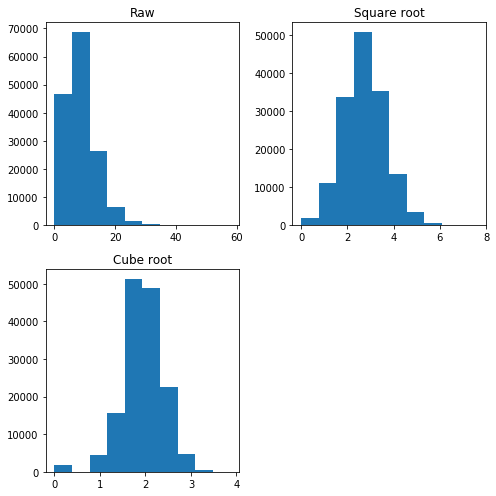

		NumberRealEstateLoansOrLines Transformations


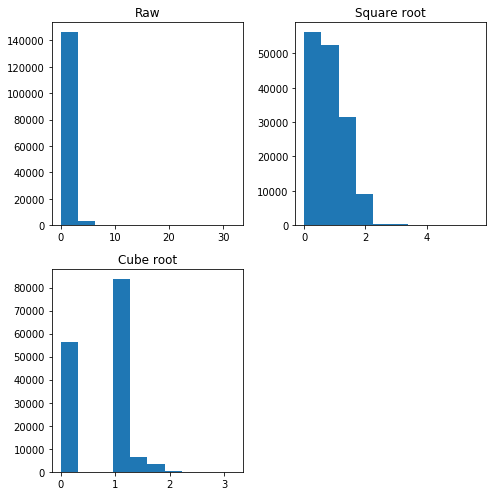

		combined_lines Transformations


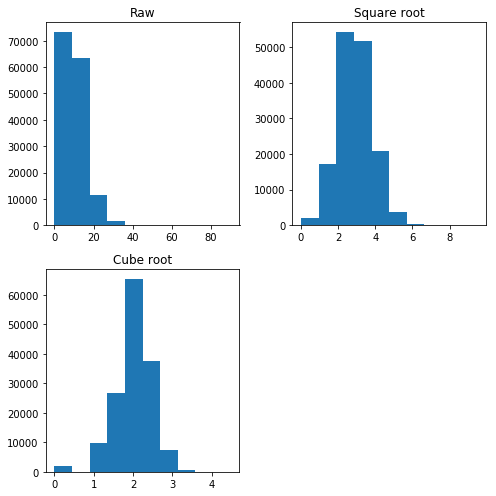

In [58]:
# Attempting transformations for various variables.
for col in ['NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'combined_lines']:
    print('\t\t{} Transformations'.format(col))
    plt.figure(figsize=(7,7))
    
    plt.subplot(221)
    plt.hist(testing123[col])
    plt.title('Raw')
    
    plt.subplot(222)
    plt.hist(np.sqrt(testing123[col]))
    plt.title('Square root')
    
    plt.subplot(223)
    plt.hist(testing123[col]**(1/3))
    plt.title('Cube root')
    plt.tight_layout()
    plt.show()

Based on the above visualizations, the square root variables are clearly the most normal and may be useful for logistic regression. I will add them for now. (I added them above in "df_transformed".)

# EDA Continued with Feature Selection

I will be comparing two populations here with plots and t-tests. The two populations will be those who defaulted and those who did not in order to see if there is a significant difference between the two and if it will be worth including in my model.

This process will require me to temporarily add back my outcome variable

Saving figure credit_boxplots


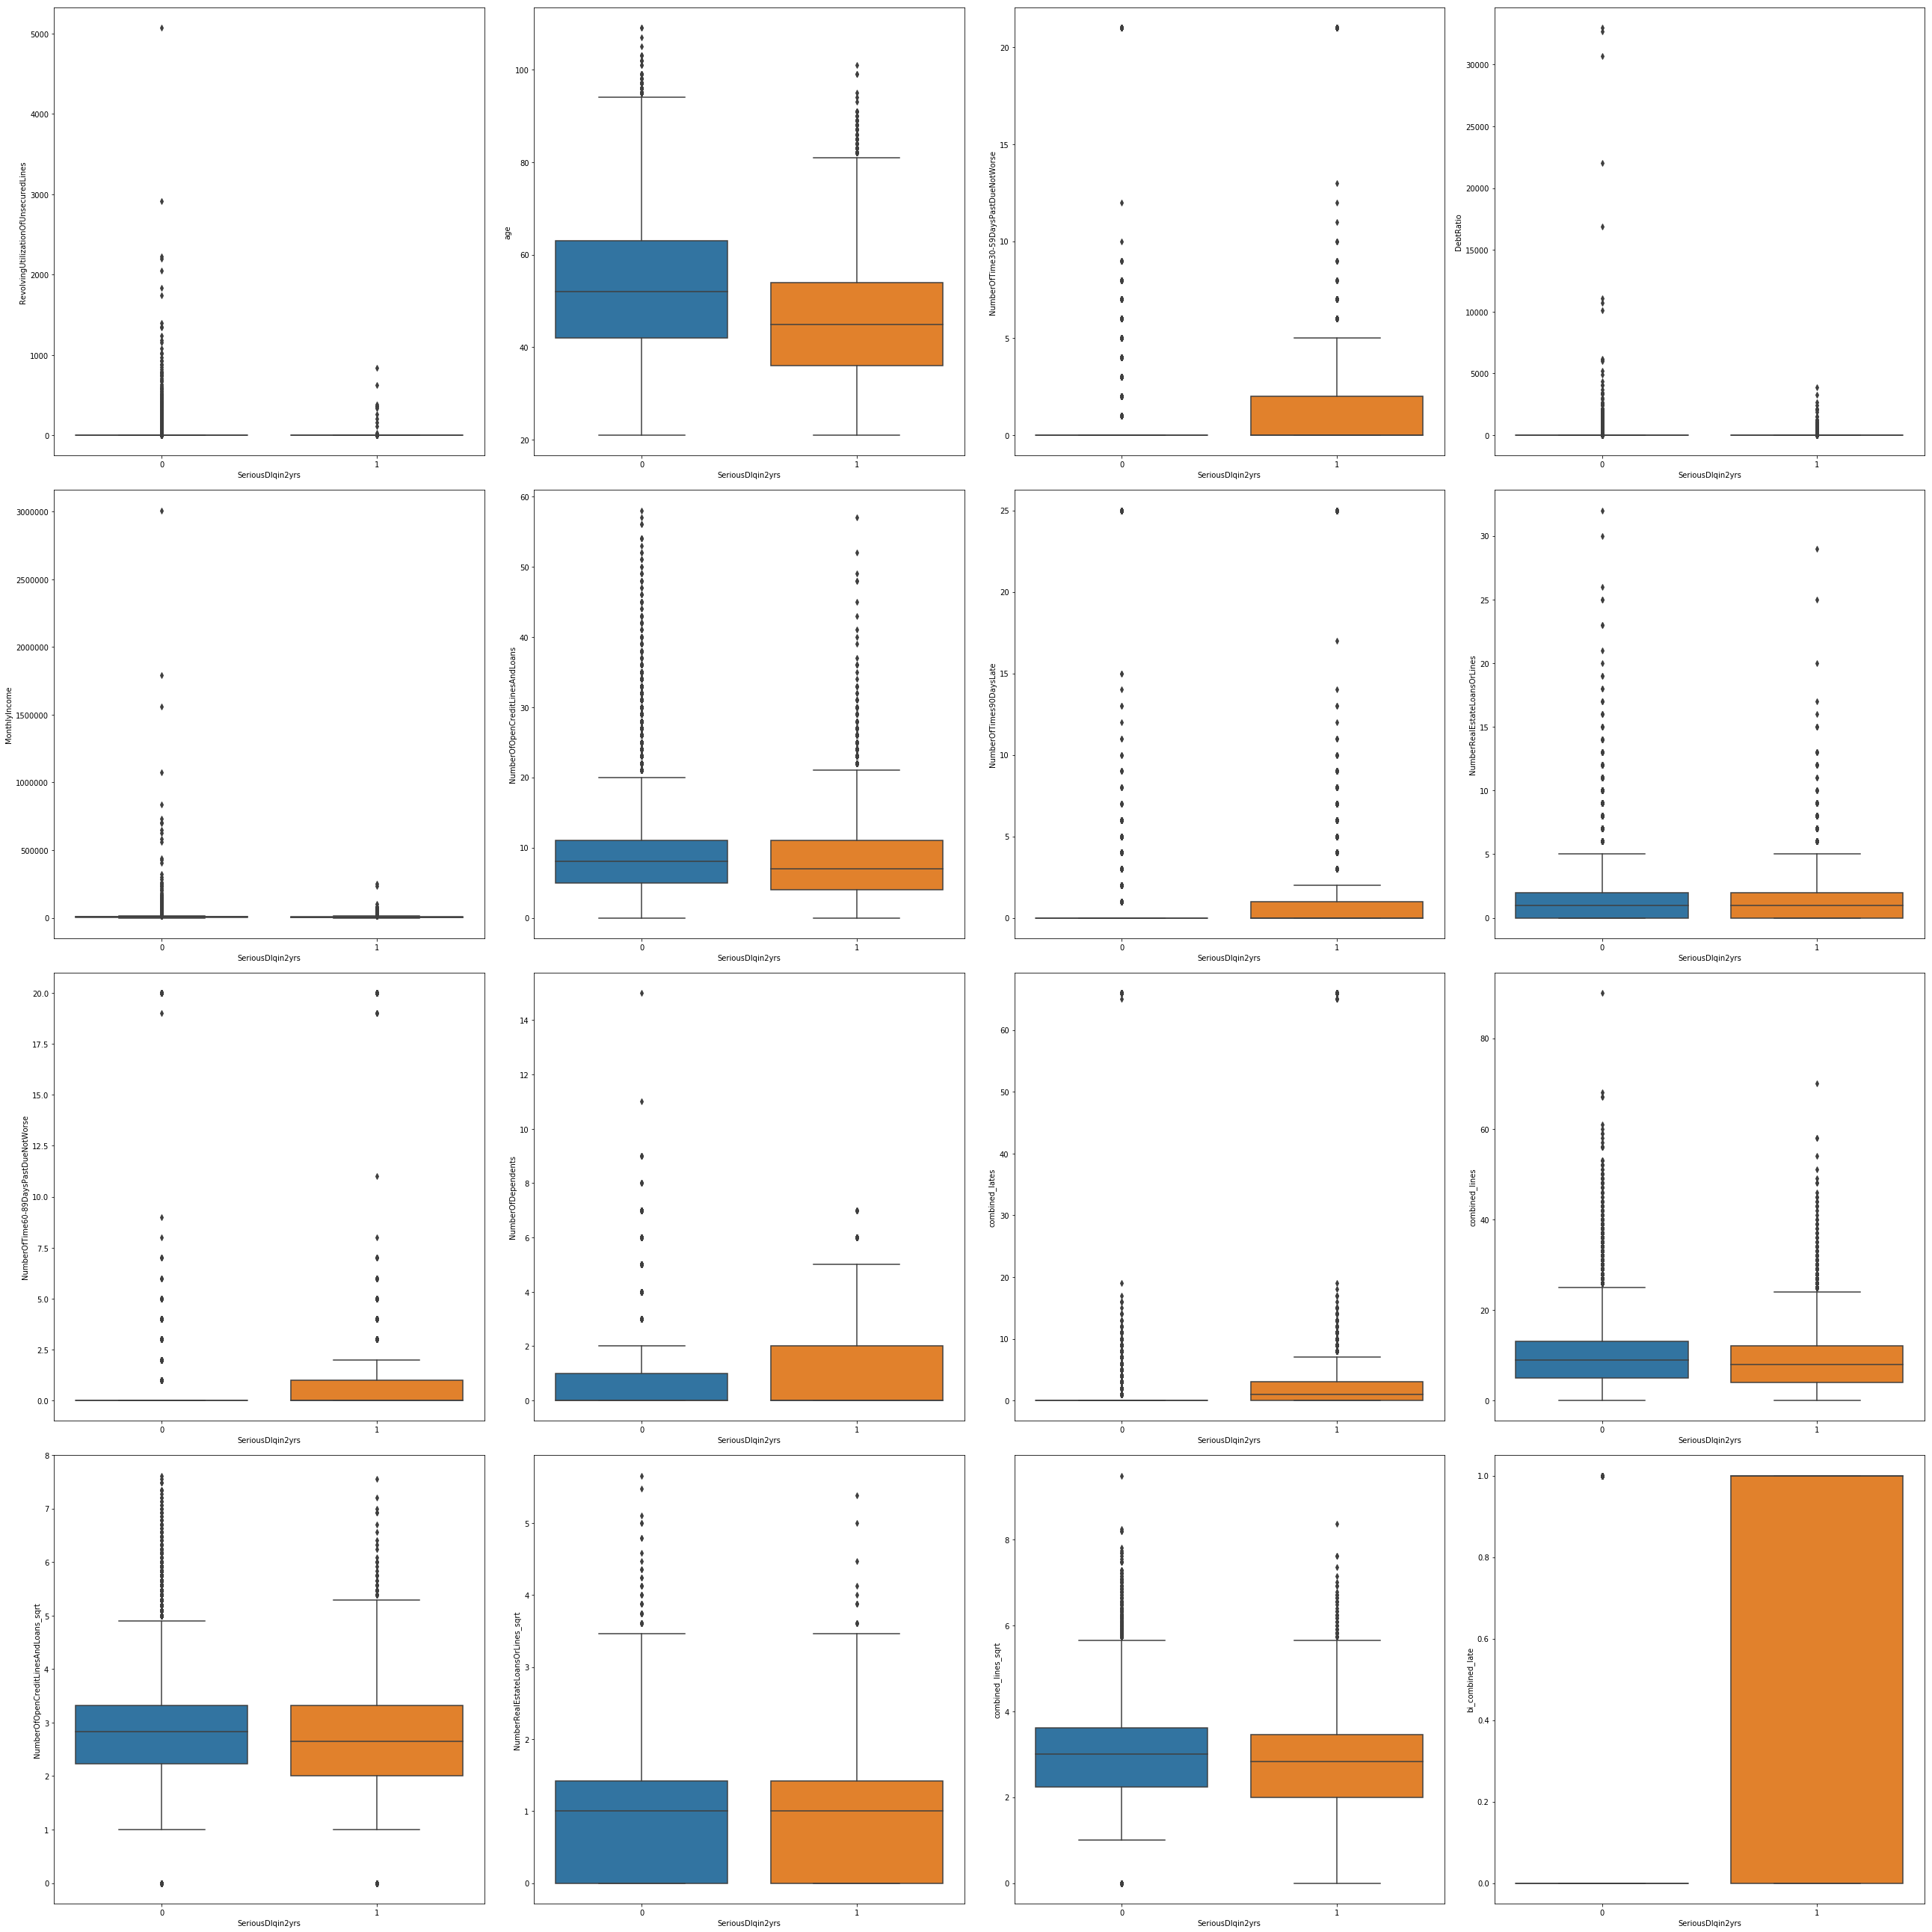

In [59]:
b = 1
plt.figure(figsize=(36, 36))
for col in testing123.columns.drop('SeriousDlqin2yrs'):
    plt.subplot(4,4,b)
    sns.boxplot(x='SeriousDlqin2yrs', y=col, data=testing123)
    b+=1
save_fig('credit_boxplots')
plt.show()

In [60]:
p_vals = []
for col in testing123.columns:
    p_vals.append([col, stats.ttest_ind(
        testing123[testing123['SeriousDlqin2yrs'] == 1][col],
        testing123[testing123['SeriousDlqin2yrs'] == 0][col]
    )[1]])
p_vals = pd.DataFrame(p_vals)
p_vals.columns = ['Feature', 'p-value']
p_vals

,Feature,p-value
0,SeriousDlqin2yrs,0.000000e+00
1,RevolvingUtilizationOfUnsecuredLines,4.653661e-01
2,age,0.000000e+00
3,NumberOfTime30-59DaysPastDueNotWorse,0.000000e+00
4,DebtRatio,3.300988e-03
5,MonthlyIncome,2.930242e-12
6,NumberOfOpenCreditLinesAndLoans,1.430210e-30
7,NumberOfTimes90DaysLate,0.000000e+00
8,NumberRealEstateLoansOrLines,6.425897e-03
9,NumberOfTime60-89DaysPastDueNotWorse,0.000000e+00


In [61]:
p_vals[p_vals['p-value'] > .05]

,Feature,p-value
1,RevolvingUtilizationOfUnsecuredLines,0.465366


We see on the boxplots that many of the variables are significantly different depending on whether the person defaulted. The p-values confirm this as RevolvingUtilizationOfUnsecuredLines is the only one where there is a p-value > .05.

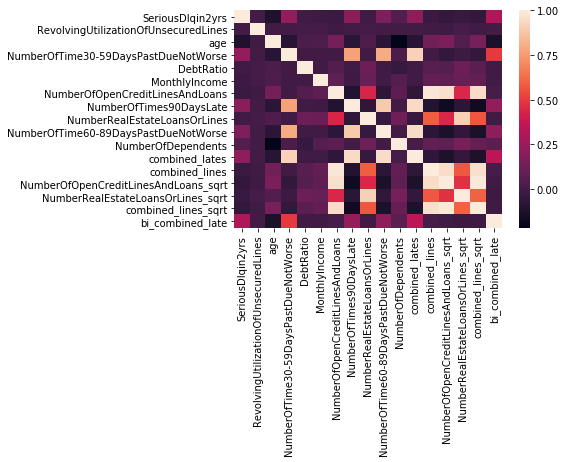

In [62]:
testing123_corr = testing123.corr()
sns.heatmap(testing123_corr)

# Feature Selection Summary:

#### p-value comparisons: defaulted vs. not defaulted:
- All variables had p-values < .05 except for RevolviingUtilizationOfUnsecuredLines, which had .46.

#### Correlation map findings:
- bi_combined_late has the highest correlation with the outcome variable.

I will have to try many different features in the models in order to optimize it properly.

In [63]:
def full_pipe(df):
    '''Applies all transformations and returns ready-to-go DataFrame'''
    df = df_monthly_income_nan(df)
    df = reduce_outliers(df)
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)
    df = df_new_features(df)
    
    upper = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
    df = df.drop(columns=to_drop)
    return df

In [64]:
to_save = credit.copy()
to_save = full_pipe(to_save)
to_save.to_csv('explore.csv')